# Meta Analysis of Circuit Breaker Invitational

Cursory analysis of the data, seeing what we can learn about the meta.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [66]:
r=requests.request(url="https://cobr.ai/tournaments/2756.json",method="GET")


In [67]:
raw_faction_data = requests.request(url="https://netrunnerdb.com/api/2.0/public/cards",method="GET").json()['data']
cards_df = pd.DataFrame(raw_faction_data)
id_df = cards_df[cards_df["type_code"] == "identity"].groupby(['stripped_title','faction_code']).size().reset_index()[['stripped_title','faction_code']]

faction_hues = {
    'shaper':'limegreen',
    'criminal':'royalblue',
    'anarch':'orangered',
    'adam':'gold',
    'jinteki':'crimson',
    'nbn':'darkorange',
    'haas-bioroid':'blueviolet',
    'weyland-consortium':'darkgreen'
}

In [68]:
raw_data = r.json()
players = pd.DataFrame(raw_data['players'])
elim_rankings = pd.DataFrame(raw_data["eliminationPlayers"])

In [69]:
aug_players = pd.merge(players, id_df, how='left',left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"corpFaction"})
aug_players = pd.merge(aug_players, id_df, how='left',left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"runnerFaction"})

In [70]:
import warnings
warnings.filterwarnings('ignore')
matches = pd.DataFrame(columns=['table','round','id','runnerScore','corpScore','combinedScore','intentionalDraw','twoForOne','eliminationGame'])
for rnd, tables in enumerate(raw_data['rounds']):
    for table_number, table in enumerate(tables):
        for player in ['player1','player2']:
            df = pd.DataFrame([table[player]])
            df['table'] = table_number
            df['round'] = rnd
            df['twoForOne'] = table['twoForOne']
            df['intentionalDraw'] = table['intentionalDraw']
            df['eliminationGame'] = table['eliminationGame']
            matches = pd.concat([matches, df],ignore_index=True)

matches.head()

,table,round,id,runnerScore,corpScore,combinedScore,intentionalDraw,twoForOne,eliminationGame,role,winner
0,0,0,30825,3,3,6,False,False,False,NaN,NaN
1,0,0,30816,0,0,0,False,False,False,NaN,NaN
2,1,0,30871,0,0,0,False,False,False,NaN,NaN
3,1,0,30875,3,3,6,False,False,False,NaN,NaN
4,2,0,30855,3,3,6,False,False,False,NaN,NaN


In [71]:
swiss_played_games = matches[(matches['intentionalDraw'] == False) & (matches['twoForOne'] == False) & (matches['eliminationGame'] == False)]
result=swiss_played_games[['runnerScore','corpScore']].agg('sum')
print(f"Runner Win Rate {round(result['runnerScore']/3/(result['corpScore']/3+result['runnerScore']/3)*100,1)}")

Runner Win Rate 39.8


In [72]:
# Uncomment this to get a table of the results from the top cut
# matches[(matches['eliminationGame'] == True) & matches['winner'] == True]

In [73]:
runner_wins = matches[(matches['eliminationGame'] == True) & (matches['winner'] == True) & (matches['role'] == "runner")].shape[0]

cut_games = matches[(matches['eliminationGame'] == True) & (matches['winner'] == True)].shape[0]

print(f"Runner Winrate (cut) {round(runner_wins/cut_games*100,1)}")

Runner Winrate (cut) 66.7


This table displays what the corp winrate was for each round. Typically the final round will have many fewer games because the data is excluding 241s and IDs (which occurr most frequently in the final round). And I'm not sure exactly why the combined score doesn't add up.

In [74]:
per_round_score = swiss_played_games.groupby(["round"]).agg(sum)
per_round_score["corp_wins"] = per_round_score["corpScore"] / (per_round_score['runnerScore'] + per_round_score['corpScore'])
per_round_score

,table,id,runnerScore,corpScore,combinedScore,intentionalDraw,twoForOne,eliminationGame,role,winner,corp_wins
round,,,,,,,,,,,
0,1332,2251860,87,129,222,0,0,0,0,0,0.597222
1,1260,2190157,81,123,215,0,0,0,0,0,0.602941
2,1190,2128445,78,120,210,0,0,0,0,0,0.606061
3,930,1912539,72,108,185,0,0,0,0,0,0.600000
4,634,1357361,60,66,132,0,0,0,0,0,0.523810
5,440,863809,18,54,84,0,0,0,0,0,0.750000


In [75]:
player_match_data = pd.merge(swiss_played_games,aug_players, on='id')
id_side_wins = player_match_data.groupby('id')[['runnerScore','corpScore']].aggregate("sum")
num_games_played_by_id = player_match_data.groupby(["id","runnerIdentity","corpIdentity"]).size().reset_index().rename(columns={0:"roundsplayed"})
rounds_played_by_id = pd.merge(id_side_wins,num_games_played_by_id,on='id')
rounds_played_by_id = pd.merge(rounds_played_by_id,id_df, left_on="runnerIdentity",right_on="stripped_title").rename(columns={"faction_code":"runnerFaction"}).drop(columns=["stripped_title"])
rounds_played_by_id = pd.merge(rounds_played_by_id,id_df, left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"corpFaction"}).drop(columns=["stripped_title"])
runner_corp_dist = rounds_played_by_id.groupby(['runnerScore','corpScore']).size().reset_index().rename(columns={0:"num_players"})

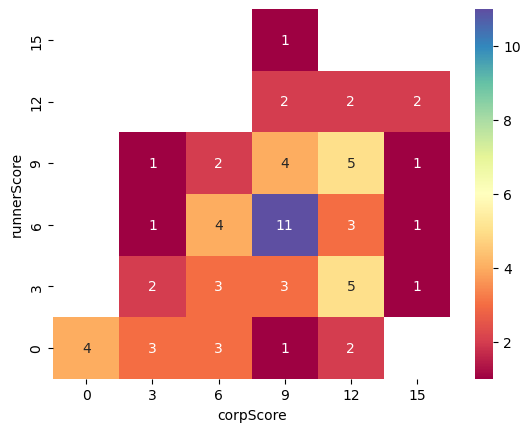

In [76]:
g = sns.heatmap(runner_corp_dist.pivot(columns="corpScore",index="runnerScore",values="num_players"),annot=True,cmap="Spectral")
g.invert_yaxis()
g.get_figure().savefig("heatmap.png")

In [77]:
rounds_played_by_id['corpWR'] = rounds_played_by_id['corpScore']/3 / rounds_played_by_id['roundsplayed']
rounds_played_by_id['runnerWR'] = rounds_played_by_id['runnerScore']/3 / rounds_played_by_id['roundsplayed']
# rounds_played_by_id.groupby(['corpWR','runnerWR']).size().reset_index().rename(columns={0:"num_players"})

<AxesSubplot: xlabel='corpWR', ylabel='runnerWR'>

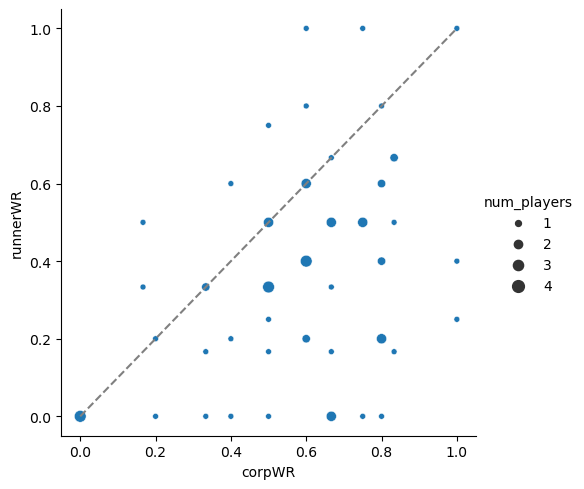

In [78]:
wr_table = rounds_played_by_id.groupby(['corpWR','runnerWR']).size().reset_index().rename(columns={0:"num_players"})
temp_df = pd.DataFrame({'x':[0,1],'y':[0,1]})


sns.relplot(wr_table, x="corpWR",y="runnerWR",size="num_players")
sns.lineplot(temp_df, x="x",y="y",color="gray",linestyle='--',legend=False)


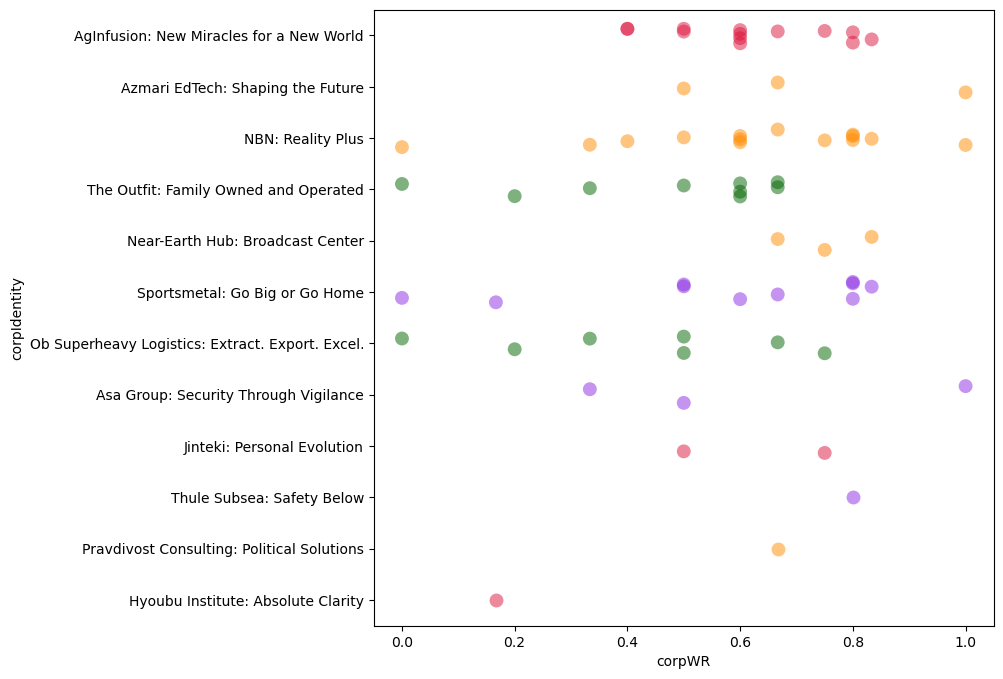

In [79]:
plt.figure(figsize=(8,8))
g=sns.stripplot(rounds_played_by_id,y="corpIdentity",x="corpWR",hue="corpFaction",palette=faction_hues,alpha=.5,size=10,jitter=.2,legend=False)
g.get_figure().savefig("corpWinrate.png",bbox_inches="tight")

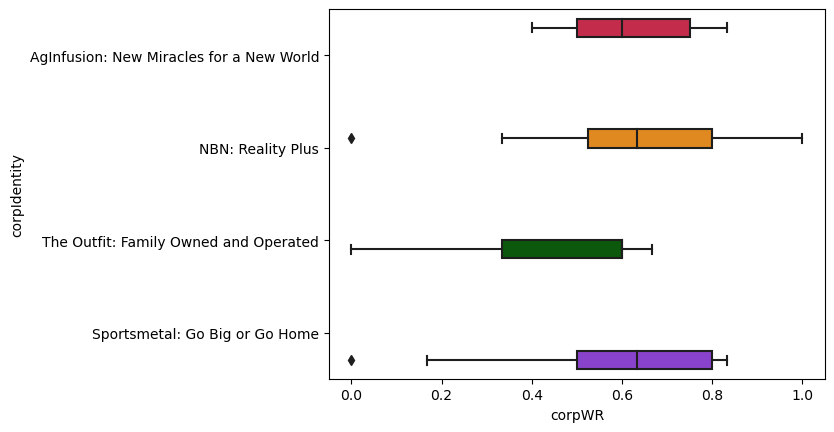

In [80]:
corp_playrate = rounds_played_by_id.groupby("corpIdentity").size().reset_index().rename(columns={0:"num_players"})
high_playrate_corps = list(corp_playrate[corp_playrate['num_players'] > 7]['corpIdentity'])
high_playrate_corps
sns.boxplot(rounds_played_by_id.query('corpIdentity in @high_playrate_corps'),x="corpWR",y="corpIdentity",hue='corpFaction',palette=faction_hues)
plt.legend().remove()

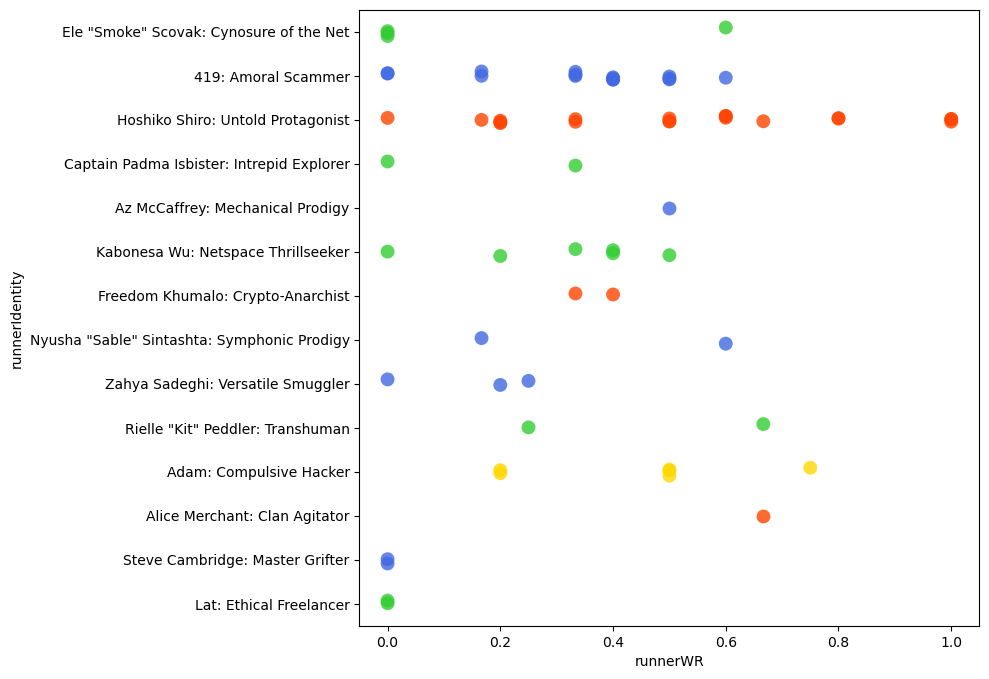

In [81]:
plt.figure(figsize=(8,8))
g=sns.stripplot(rounds_played_by_id,y="runnerIdentity",x="runnerWR",hue='runnerFaction',palette=faction_hues,alpha=.8,size=10)
g.get_figure().savefig("runnerWinrate.png",bbox_inches="tight")
g.legend().remove()

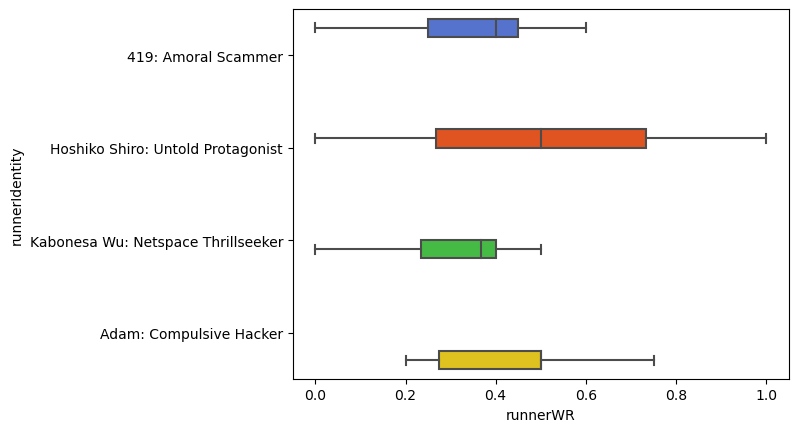

In [82]:
runner_playrate = rounds_played_by_id.groupby("runnerIdentity").size().reset_index().rename(columns={0:"num_players"})
high_playrate_runners = list(runner_playrate[runner_playrate['num_players'] > 5]['runnerIdentity'])
sns.boxplot(rounds_played_by_id.query('runnerIdentity in @high_playrate_runners'),x="runnerWR",y="runnerIdentity",hue="runnerFaction",palette=faction_hues)
plt.legend().remove()